# Cycle analysis
Sample workflow for cell cycle analysis of *E. coli* grown in LB (Dataset D1).

Please note: the scVI method `model.get_normalized_expression()` involves random sampling, performing it multiple times using the same model/data will give slightly different results. When originally running this code, we unfortunately did not set a seed, making it hard to precisely reproduce the results. Therefore, running this notebook will produce slightly different results from those reported in the paper (we do not anticipate that this will change any of the conclusions drawn in the paper). We have included the original outputs used in the paper within the `samples` folder.

In [31]:
# Import libraries
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import seaborn as sns
import scvi

# Set plotting parameters
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Load in data. Here, we are going to load in the same scVI model used in the paper (but you can load in the output model from `initial_processing.ipynb`).

In [2]:
adata = sc.read_h5ad('outputs/lb_adata.h5ad')
model = scvi.model.SCVI.load('samples/D1_scVI_model', adata)

INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 57627 cells, 3070 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Load in the GFF:

In [3]:
gff = pd.read_csv("reference/GCF_000005845.2_ASM584v2_genomic.gff.gz",
                 sep="\t", comment='#', names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
chrom_length = gff.loc[0, 'end']

gff['name'] = gff['attribute'].str.replace("^.*;Name=", "", regex=True).str.replace(";.*$", "", regex=True)
gff['locus_tag'] = gff['attribute'].str.replace("^.*;locus_tag=", "", regex=True).str.replace(";.*$", "", regex=True)

# Select rRNA genes
rRNA_genes = gff.loc[gff['feature'] == 'rRNA', 'locus_tag']

gff = gff[gff['feature'] == 'gene']
gff = gff[['chrom', 'start', 'end', 'strand', 'name', 'locus_tag']]
gff.reset_index(inplace=True)

def set_coord(x):
    if x['strand'] == '+':
        return x['start']
    elif x['strand'] == '-':
        return x['end']
    else:
        raise ValueError('Strand should not be ' + x['strand'])

gff['coord'] = gff.apply(set_coord, axis=1)
gff.index = gff['locus_tag']

# Start of the replication origin - Taken directly from the genbank annotation
origin_start = 3925744
origin_end = 3925975
origin_midpoint = (origin_start + origin_end) / 2
origin_midpoint

gff = gff.loc[pd.Series(adata.var_names),:]
gff['coord'] = (gff['coord'] - origin_midpoint) % chrom_length
gff = gff.sort_values('coord')

# Filter out extrachromosomal genes (not necessary for E. coli MG1655 since there are no plasmids):
gff = gff.loc[gff['chrom'] == 'NC_000913.3']

### 1. Deriving cell angles
We use the UMAP-based approach to derive cell angles (cell cycle states).

First, get the scVI-smoothed data and log-transform and scale it:

In [4]:
scvi.settings.seed = 123

normalized_expression = pd.DataFrame(model.get_normalized_expression(adata),
                                 index=adata.obs_names, columns=adata.var_names)
normalized_expression = normalized_expression[gff.index]
log_expression = np.log2(normalized_expression)
scaled_expression = log_expression.apply(lambda x: (x - np.mean(x)) / np.std(x), 0)

Do UMAP analysis. Let's start by doing it on the unbinned data. As we see, we get a rather formless blob from this:

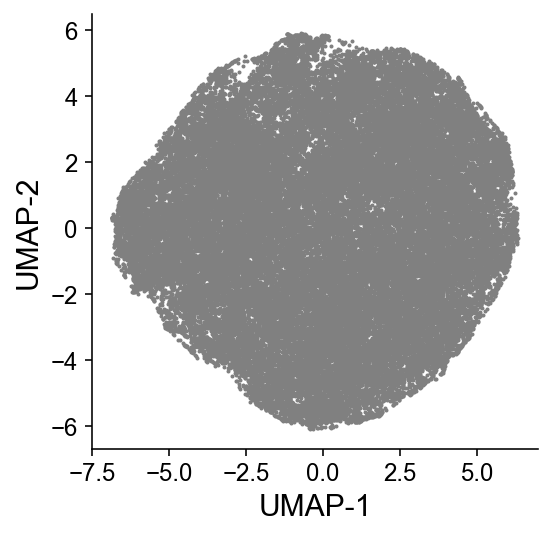

In [5]:
import umap

fit = umap.UMAP(metric='correlation', random_state=123)
embeddings_unbinned = fit.fit_transform(scaled_expression)
embeddings_unbinned = embeddings_unbinned - embeddings_unbinned.mean(axis=0)[np.newaxis,:]

plt.figure(figsize=(4,4))
plt.rc('axes', labelsize=15)     # fontsize of the axes title
plt.scatter(embeddings_unbinned[:,0], embeddings_unbinned[:,1], s=1.0, color='grey')
plt.xlabel('UMAP-1', fontsize=15)
plt.ylabel('UMAP-2', fontsize=15)
plt.show()

We can remove a lot of the noise by binning into 100 kb bins along the chromosome (note this is the same binning approach used to create the chromsome-wide correlation plots):

In [7]:
from collections import OrderedDict
from scipy.stats import spearmanr


### Function to create bins
# This creates an ordered dictionary where each key is a chromosomal region and each key is a list of genes
# in that bin.
def create_bins(gff, chrom_length, bin_size):
    bins = OrderedDict()
    if type(bin_size) is float:
        bin_size = int(bin_size)
    for bin_start in range(1, chrom_length + 1, bin_size):
        bin_end = bin_start + bin_size - 1
        if bin_end > chrom_length:
            bin_end = chrom_length
        bins[(bin_start, bin_end)] = list(gff.loc[(bin_start <= gff['coord']) & (gff['coord'] <= bin_end), 'locus_tag'])
    return bins

### Function to create binned expression
# This takes the bin dictionary and averages gene expression within each bin.
def bin_expression(counts, bins):
    bin_names = []
    binned_expression = []
    for bin in bins:
        bin_names.append((bin[0] + bin[1]) / 2)
        binned_expression.append(counts.loc[:,np.isin(counts.columns, bins[bin])].mean(axis=1))
    binned_expression_df = pd.DataFrame(binned_expression).transpose()
    binned_expression_df.columns = bin_names
    return binned_expression_df

Use these functions to create expression averaged in 100 kb bins (we do it on the scaled data to allow averaging of expression of genes at very different abundance levels):

In [9]:
bins = create_bins(gff, chrom_length, 1e5)
binned_expression = bin_expression(scaled_expression, bins)

# Re-scale after binning
binned_expression_scaled = np.apply_along_axis(lambda x: (x - np.mean(x)) / np.std(x), 0, binned_expression)

Now fit a UMAP. If you want to reproduce the exact embeddings from the paper, these are available in `samples/lb_umap_embeddings.txt`).

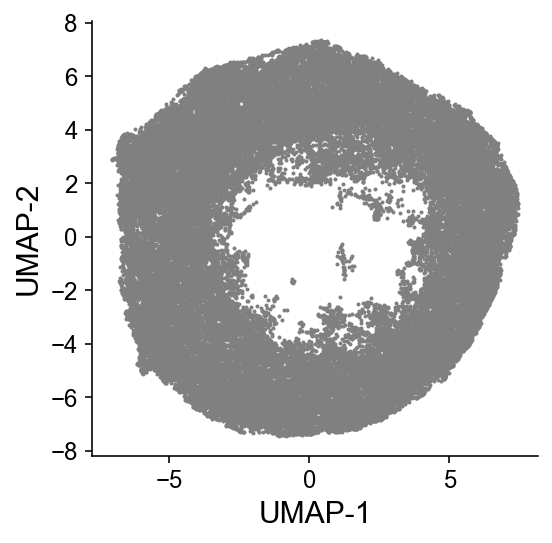

In [12]:
fit = umap.UMAP(metric='correlation', random_state=123)
embeddings = fit.fit_transform(binned_expression_scaled)

# Zero-center the embeddings (this makes calculating the cell angle more straightforward)
embeddings = embeddings - embeddings.mean(axis=0)[np.newaxis,:]

plt.figure(figsize=(4,4))
plt.scatter(embeddings[:,0], embeddings[:,1], s=1.0, color='grey')
plt.xlabel('UMAP-1', fontsize=15)
plt.ylabel('UMAP-2', fontsize=15)
plt.show()

Now we can use this plot to calculate the cell angles:

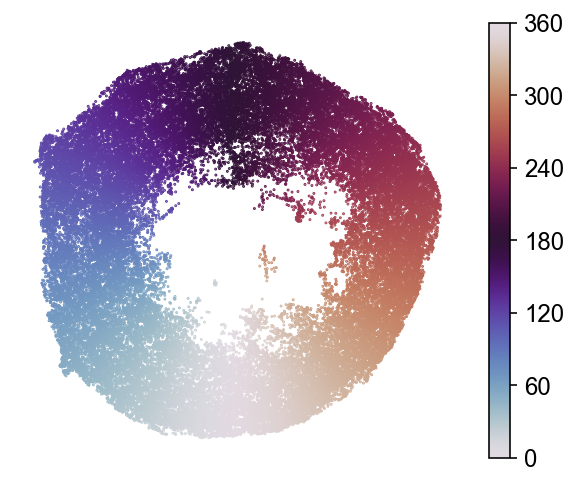

In [18]:
from math import pi

cell_angles = 180 + (180 / pi) * np.arctan2(embeddings[:,0], embeddings[:,1])

plt.figure(figsize=(5,4))
ax = plt.scatter(embeddings[:,0], embeddings[:,1], s=0.2, c=cell_angles,
                 cmap='twilight', vmin=0, vmax=360)
plt.xlabel('UMAP-1', fontsize=15)
plt.ylabel('UMAP-2', fontsize=15)
plt.axis('off')
cbar = plt.colorbar(ax, ticks=[0, 60, 120, 180, 240, 300, 360])

Again, there will be slight numerical differences between cell angles calculated in this notebook and cell angles used in the paper. The original cell angles are included in `samples/lb_cell_angles.txt`.

As a point of interest, let's compare the new cell angles from the cell angles in the paper as a density plot:

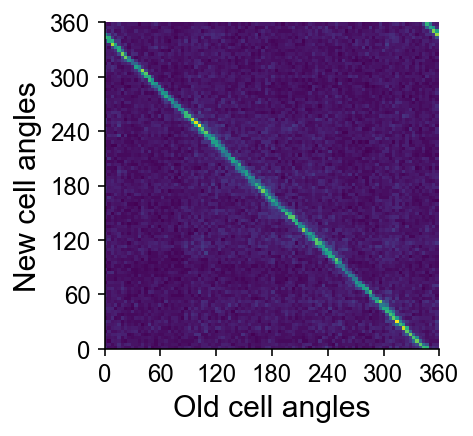

In [27]:
plt.figure(figsize=(3,3))
plt.hist2d(pd.read_table('samples/lb_cell_angles.txt', index_col=0)['cell_angle'], cell_angles, bins=100)
plt.xticks([0, 60, 120, 180, 240, 300, 360]); plt.yticks([0, 60, 120, 180, 240, 300, 360])
plt.xlabel('Old cell angles', size=15); plt.ylabel('New cell angles', size=15)
plt.show()

Note that there is clearly a very strong, linear overlap between the two. However, the orientation is different (the relationship is inverse). This is because the orientiation of axes on the UMAP is arbitary. We always check the relationship between angle and expression and flip if needed (see below). Also note that the phase is slightly different (see the top right corner of the plot), arising because the initial zero cell angle is arbitrary. We standardize this later.

We can also project these angles onto the unbinned UMAP. This shows that the binning helps to form the wheel by reducing noise, but actually the ordering of the cells is still largely conserved even in the unbinned "blob":

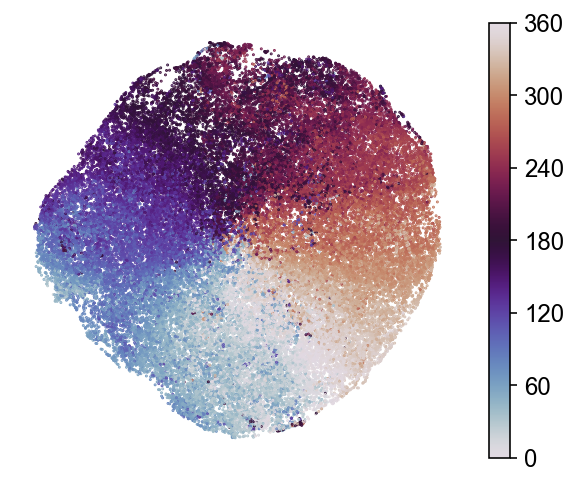

In [28]:
plt.figure(figsize=(5,4))
ax = plt.scatter(embeddings_unbinned[:,0], embeddings_unbinned[:,1], s=0.2, c=cell_angles,
                 cmap='twilight', vmin=0, vmax=360)
plt.xlabel('UMAP-1', fontsize=15)
plt.ylabel('UMAP-2', fontsize=15)
plt.axis('off')
cbar = plt.colorbar(ax, ticks=[0, 60, 120, 180, 240, 300, 360])

Finally, we can bin gene expression by cell angle to get our 100 bins used throughout the paper:

In [36]:
binned_angles = np.zeros(len(cell_angles))

angle_bins = np.linspace(0, 360, 101)

for i in range(len(angle_bins) - 1):
    binned_angles[(cell_angles >= angle_bins[i]) & (cell_angles < angle_bins[i+1])] = i
    
angle_binned_expression = pd.DataFrame(scaled_expression).\
    assign(angle_bin = binned_angles).groupby('angle_bin').mean()
angle_binned_expression.index = np.array(pd.DataFrame(cell_angles).assign(bin=binned_angles).groupby('bin').mean()).squeeze()

Now plot this. Note that initially the angles are the reverse of that seen in the paper. As explained above, this is because the orientation of UMAP is arbitrary (and highly sensitive to initiation conditions).

<Figure size 288x288 with 0 Axes>

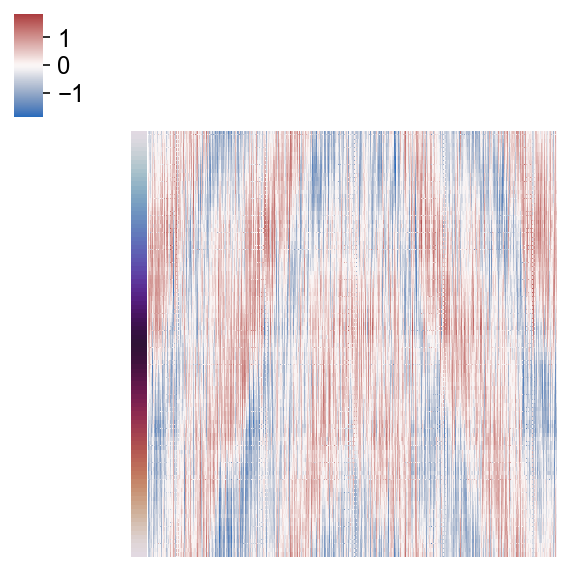

In [37]:
norm = mplc.Normalize(vmin=0, vmax=360)
cell_mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.twilight)
rgb = cell_mapper.to_rgba(angle_binned_expression.index)
cell_angle_colors = np.apply_along_axis(lambda x: mplc.to_hex(x), 1, rgb)

plt.figure(figsize=(4,4))
sns.clustermap(np.array(angle_binned_expression), cmap='vlag',
               center=0,
               row_cluster=False, col_cluster=False,
               xticklabels=False, yticklabels=False,
               row_colors=cell_angle_colors,
               figsize=(4,4))

So we just flip the direction of the angles:

In [ ]:
cell_angles = 360 - cell_angles

Then plot again:

<Figure size 288x288 with 0 Axes>

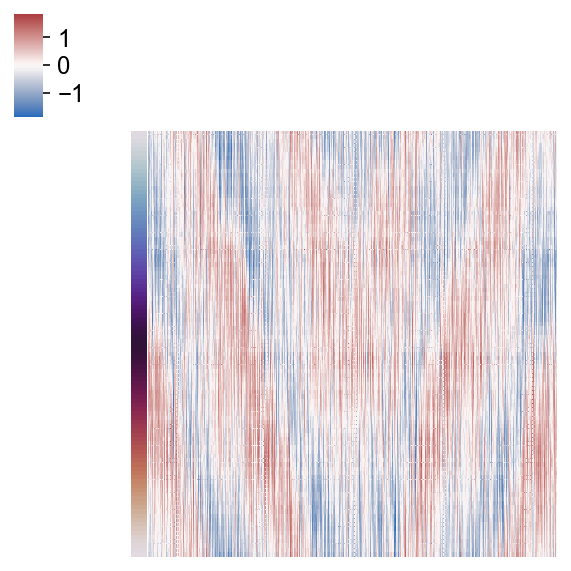

In [40]:
binned_angles = np.zeros(len(cell_angles))

angle_bins = np.linspace(0, 360, 101)

for i in range(len(angle_bins) - 1):
    binned_angles[(cell_angles >= angle_bins[i]) & (cell_angles < angle_bins[i+1])] = i

angle_binned_expression = pd.DataFrame(scaled_expression).\
    assign(angle_bin = binned_angles).groupby('angle_bin').mean()
angle_binned_expression.index = np.array(pd.DataFrame(cell_angles).assign(bin=binned_angles).groupby('bin').mean()).squeeze()

plt.figure(figsize=(4,4))
sns.clustermap(np.array(angle_binned_expression), cmap='vlag',
               center=0,
               row_cluster=False, col_cluster=False,
               xticklabels=False, yticklabels=False,
               row_colors=cell_angle_colors,
               figsize=(4,4))

We save the expression matrix as follows.

For the sake of reproducibility, again the angle binned expression matrix used in the paper is available at `samples/lb_binned_expression_scvi.txt`.

In [71]:
angle_binned_expression.to_csv('outputs/lb_binned_expression_scvi.txt', sep="\t")

### 2. Deriving observed and predicted gene angles
To get gene angles, we just take the transpose of the binned expression matrix above and do PCA on it. Gene angles are the angles relative to the origin and PCs 1 and 2.

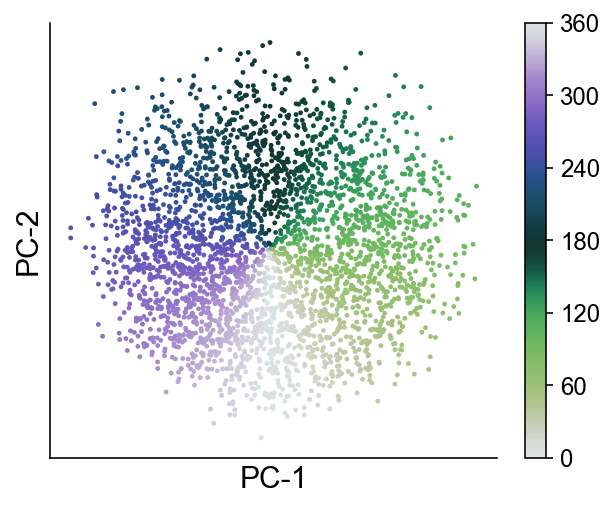

In [47]:
from sklearn.decomposition import PCA

gene_pca = PCA(n_components=2, svd_solver='arpack').fit_transform(angle_binned_expression.transpose())

gene_angles = 180 + (180 / pi) * np.arctan2(gene_pca[:,0], gene_pca[:,1])
gene_angles = 360 - gene_angles # Flip as for cell angles (PCA orientiation is also arbitrary)

gene_mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.twilight)
rgb = cell_mapper.to_rgba(gene_angles[np.argsort(gene_angles)])
new_rgb = np.column_stack((rgb[:,1], rgb[:,2], rgb[:,0], rgb[:,3]))
gene_angle_colors = np.apply_along_axis(lambda x: mplc.to_hex(x), 1, new_rgb)
gene_cmap = mplc.LinearSegmentedColormap.from_list('gene_colors', gene_angle_colors)

plt.figure(figsize=(5,4))
plt.scatter(gene_pca[:,0], gene_pca[:,1], s=2, c=gene_angles,
           cmap=gene_cmap, vmin=0, vmax=360)
plt.xlabel('PC-1', fontsize=15)
plt.ylabel('PC-2', fontsize=15)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
plt.colorbar(ticks=[0, 60, 120, 180, 240, 300, 360])

Text(0, 0.5, 'Gene angle')

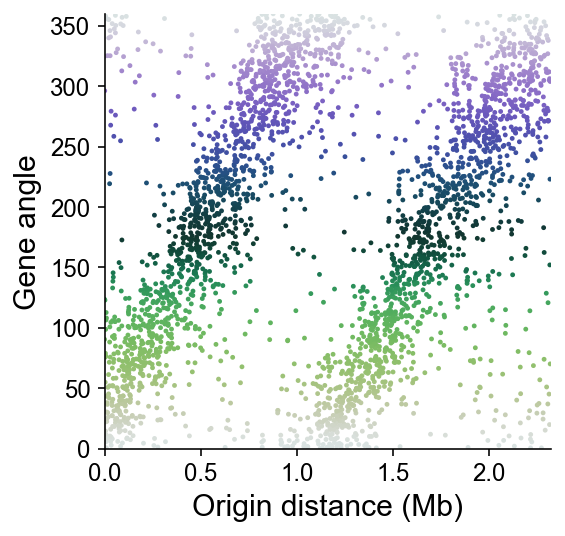

In [48]:
gff['origin_distance'] = np.minimum(gff['coord'], np.abs(chrom_length - gff['coord']))

plt.figure(figsize=(4,4))
plt.scatter(gff.loc[angle_binned_expression.columns, 'origin_distance'] / 1e6,
            gene_angles, s=2, 
            c=gene_angles, cmap=gene_cmap)
plt.xlim(0, chrom_length / 2e6)
plt.ylim(0, 360)
plt.xlabel('Origin distance (Mb)')
plt.ylabel('Gene angle')

The next stage is to do the regression analysis for prediction of gene angles based on the origin distance. We do this externally in R using the Rstan package. Therefore, we need to save the data. We scale both gene angles and origin distances from -pi to pi, which allows us to treat both as angles in radians within the model:

In [49]:
dat = {
    'N': len(gene_angles),
    'D': 2 * pi * np.array(gff.loc[angle_binned_expression.columns, 'origin_distance']) / (chrom_length / 2.0) - pi,
    'A': 2 * pi * gene_angles / 360 - pi
}
pd.DataFrame(dat).to_csv('outputs/lb_origin_angle_scaled.txt', sep="\t")

The next bit needs to be run in R studio using the script `origin_angle_circular_model.R`. For the training data, fitted model in the paper and predicted angles, see:

- Training data: `samples/lb_origin_angle_scaled.txt`
- Fitted model: `samples/lb_stanfit.rds`
- Predicted angles: `samples/lb_predicted_angle.txt`

There are also a few of important values we get from this:

- The gradient `k` (used to compute the overlap fraction): 1.912446 (1.910868 in the original model) (referred to as gamma in the paper - so gamma = 1.912446 gives 1 - 1/gamma = 0.48)
- The predicted angle (in radians) of a gene at the origin (used to standardize cell angles below): -2.620387 (-2.511148 in the original model)
- DNA polymerase speed: 777.9088 bp/s (778.5513 bp/s in the original model)

Finally, we can load back in the predicted gene angles and superimpose these on the plot above:

Text(0, 0.5, 'Gene angle')

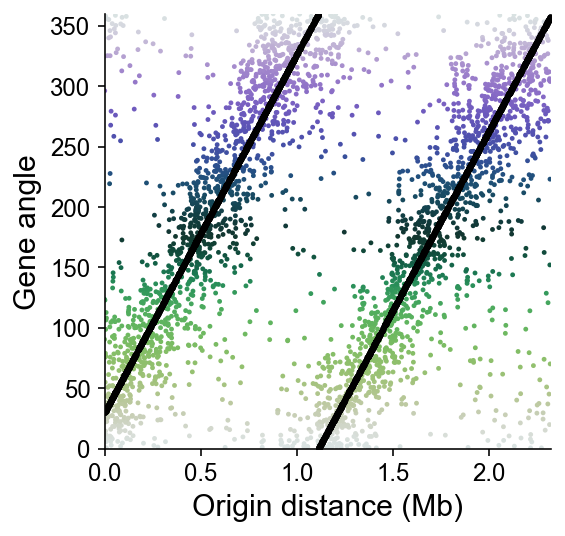

In [60]:
predicted_angles = pd.Series(pd.read_table('outputs/lb_predicted_angle.txt', index_col=0).iloc[:,0])
predicted_angles_radians = predicted_angles

# Convert back to degrees
predicted_angles = 180 * predicted_angles / pi + 180

plt.figure(figsize=(4,4))
plt.scatter(gff.loc[angle_binned_expression.columns, 'origin_distance'] / 1e6,
            gene_angles, s=2, 
            c=gene_angles, cmap=gene_cmap)
plt.scatter(gff.loc[angle_binned_expression.columns, 'origin_distance'] / 1e6,
            predicted_angles, s=4, color='black')

plt.xlim(0, chrom_length / 2e6)
plt.ylim(0, 360)
plt.xlabel('Origin distance (Mb)')
plt.ylabel('Gene angle')

### 3. Developing a prediction of cell cycle gene expression based on origin position:
We do this by first developing a matrix of expression binned 1) by cell angle, as above then 2) by gene angle. We then have to convert this into long format to provide training data for the regression model in sklearn:

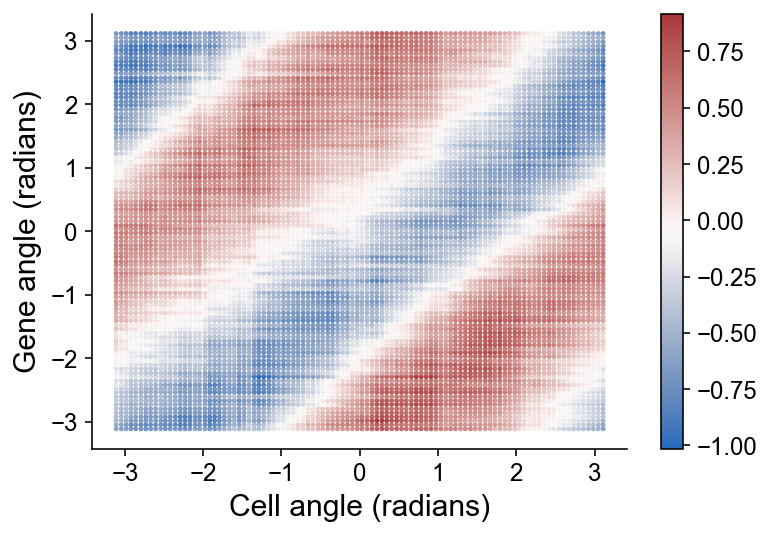

In [61]:
cell_angle_means = np.array(angle_binned_expression.index)
cell_angle_means_radians = pi * cell_angle_means / 180 - pi # Convert to radians

# Get gene angles in 100 bins (taking an average within each bin and then converting to radians)
angle_bins = np.linspace(0, 360, 101)
gene_binned_angles = np.zeros(len(gene_angles))

for i in range(len(angle_bins) - 1):
    gene_binned_angles[(gene_angles >= angle_bins[i]) & (gene_angles < angle_bins[i+1])] = i

gene_angle_means = np.array(pd.DataFrame(gene_angles).assign(bin=gene_binned_angles).groupby('bin').mean()).squeeze()
gene_angle_means_radians = pi * gene_angle_means / 180 - pi # Convert to radians

# Get a matrix of expression averaged first by cell angle (above) and then by gene angle 
double_angle_binned_expression = pd.DataFrame(angle_binned_expression.transpose()).\
    assign(angle_bin = gene_binned_angles).groupby('angle_bin').mean()

# Generate the training data for sklearn
X = np.column_stack((np.repeat(cell_angle_means_radians, len(gene_angle_means_radians)),
                     np.tile(gene_angle_means_radians, len(cell_angle_means_radians))))
y = np.array(double_angle_binned_expression.transpose()).flatten()

# Visualize this relationship
plt.scatter(X[:,0], X[:,1], c=y, s=2.0, cmap='vlag')
plt.xlabel('Cell angle (radians)'); plt.ylabel('Gene angle (radians)')
plt.colorbar()
plt.show()

We can save this comparison (the exact matrix used in the paper is at `samples/cell_angle_gene_angle_relationship.txt`):

In [62]:
pd.DataFrame({'cell_angle': X[:,0], 'gene_angle': X[:,1], 'expression': y}).\
    to_csv('outputs/cell_angle_gene_angle_relationship.txt', sep="\t", index=False)

Now we build the regression model. We make features based on the sine and cosine of each angle, and polynomial interactions between each. To do this, we use the `PolynomialFeatures` function:

In [63]:
from sklearn.preprocessing import PolynomialFeatures

def make_interaction_matrix(X, interactions_only=True, degree=4):
    X_sincos = np.array((
    np.sin(X[:,0]), np.cos(X[:,0]), np.sin(X[:,1]), np.cos(X[:,1])
        )).transpose()
    poly = PolynomialFeatures(interaction_only=interactions_only,include_bias = False, degree=degree)
    interaction_features = poly.fit_transform(X_sincos)
    return np.concatenate((X, interaction_features), axis=1)

X_full = make_interaction_matrix(X, interactions_only=False)
X_full.shape

(10000, 71)

This makes 71 features in total, making this a very flexible model. Next, we fit the regression model. We use a bit of ridge (L2) regularization to stop this model from over-fitting the data:

In [64]:
from sklearn.linear_model import Ridge

lm = Ridge(alpha=10).fit(X_full, y)

Finally, we use this to predict gene expression for the full set of genes. This becomes essentially a smoothed version of the plot above:

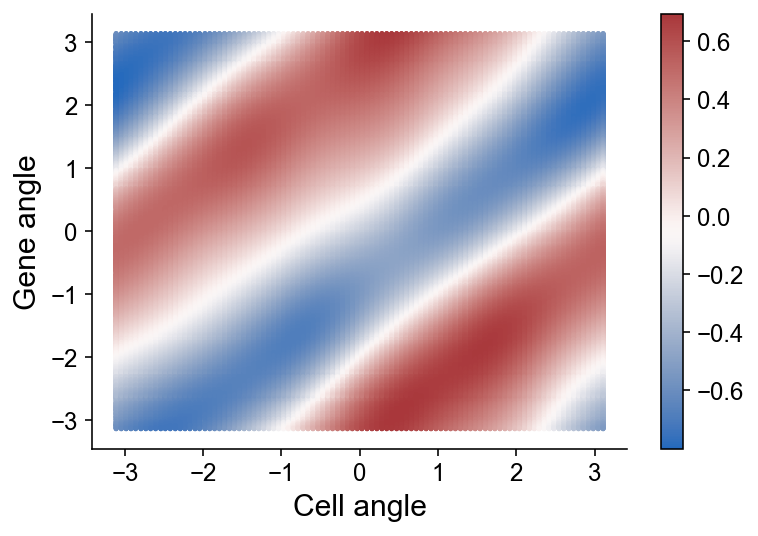

In [65]:
X_pred = np.column_stack((
    np.repeat(cell_angle_means_radians, len(predicted_angles_radians)),
    np.tile(predicted_angles_radians, len(cell_angle_means_radians))))

X_pred_full = make_interaction_matrix(X_pred, interactions_only=False, degree=4)

y_pred = lm.predict(X_pred_full)
plt.scatter(X_pred[:,0], X_pred[:,1], c=y_pred, s=2.0, cmap='vlag')
plt.xlabel('Cell angle'); plt.ylabel('Gene angle')
plt.colorbar()
plt.show()

Now we can check how good a job this does. Firstly, the correlation between predicted and observed data is fairly good:

PearsonRResult(statistic=0.5903861884574739, pvalue=0.0)


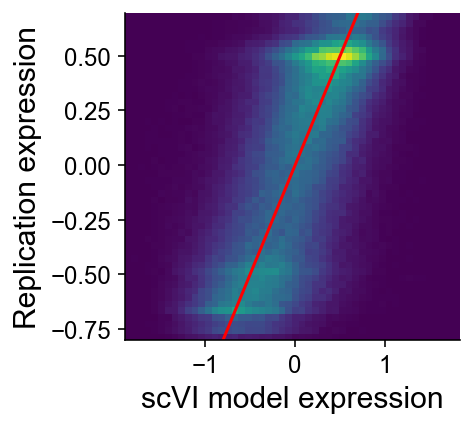

In [67]:
from scipy.stats import pearsonr

plt.figure(figsize=(3,3))

# Get a flattened version of the predicted data
replication_expression = y_pred.reshape(angle_binned_expression.shape)

# Print the Pearson correlation between predicted and observed
print(pearsonr(np.array(angle_binned_expression).flatten(), replication_expression.flatten()))

# Flatten both matrices and plot one against the other - visualize these as a density plot
plt.hist2d(np.array(angle_binned_expression).flatten(), replication_expression.flatten(), bins=50)

# Plot what a perfect 1:1 relationship would look like
plt.plot(np.linspace(-5,5,100), np.linspace(-5,5,100), c='red')

plt.xlabel('scVI model expression'); plt.ylabel('Replication expression')
plt.show()

We can also assess how well this captures the global replication effect by looking at gene-gene correlations at the predicted and observed angle-binned expression matrices, and the difference between the two:

<AxesSubplot:>

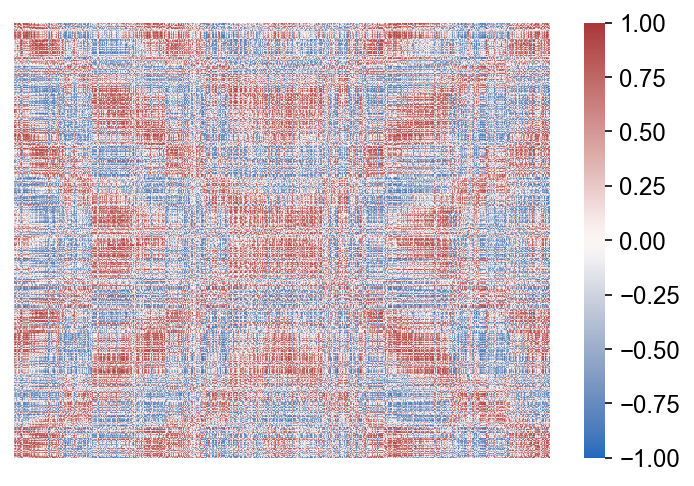

In [68]:
# Observed data
cors = spearmanr(angle_binned_expression)[0]
sns.heatmap(cors, center=0, vmin=-1, vmax=1, cmap='vlag', xticklabels=False, yticklabels=False)

<AxesSubplot:>

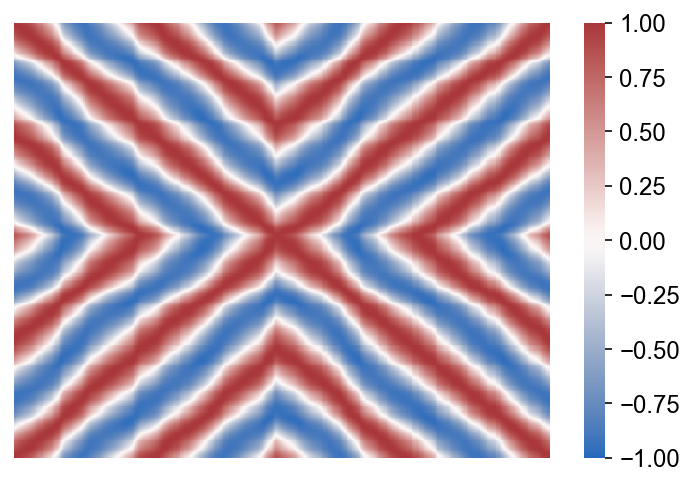

In [69]:
# Replication-predicted data
replication_expression = pd.DataFrame(replication_expression,
                                      index=angle_binned_expression.index,
                                      columns=angle_binned_expression.columns)

cors = spearmanr(replication_expression)[0]
sns.heatmap(cors, center=0, vmin=-1, vmax=1, cmap='vlag', xticklabels=False, yticklabels=False)

<AxesSubplot:>

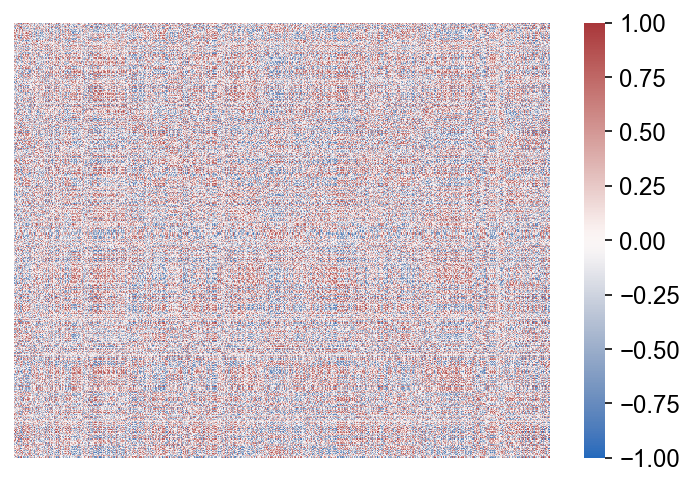

In [70]:
# Difference between observed and predicted data
corrected_expression = angle_binned_expression - replication_expression
cors = spearmanr(corrected_expression)[0]
sns.heatmap(cors, center=0, vmin=-1, vmax=1, cmap='vlag', xticklabels=False, yticklabels=False)

What this shows is that the predicted data are essentially a smoothed version of the observed data. The corrected data (observed - predicted) shows that the correlation is almost eliminated. This suggests that our model captures the majority of the chromosome position-dependent signal.

The replication-predicted gene expression matrix is saved as follows (note - the matrix used in the paper is available at `samples/lb_binned_expression_predicted.txt`):

In [72]:
replication_expression.to_csv('outputs/lb_binned_expression_predicted.txt', sep="\t")

### 4. Identifying variable genes
We describe a method in the paper to identify genes based on 1) relatively high variability within the cell cycle and 2) divergence from replication-predicted expectations. This can be can be carried out as follows:

**Identifying highly variable genes**

First, we need a course-grained average of expression within the cell cycle (here we use the raw counts instead of the scVI-smoothed data).

In [73]:
# Import counts and filter for the correct barcodes
counts = pd.read_table('outputs/lb_raw_counts.txt.gz', index_col=0)
counts = counts.loc[adata.obs_names]

# Transform into transcripts per median (i.e. total UMI-normalized expression multiplied by median UMI/barcode)
tpm = np.median(counts.sum(axis=1)) * counts.apply(lambda x: x / np.sum(x), axis=1)
tpm = tpm[angle_binned_expression.columns]

# Bin in 20 bins of cell angle
coarse_angle_bins = np.linspace(0, 360, 21)

coarse_cell_binned_angles = np.zeros(len(cell_angles))

for i in range(len(coarse_angle_bins) - 1):
    coarse_cell_binned_angles[(cell_angles >= coarse_angle_bins[i]) & (cell_angles < coarse_angle_bins[i+1])] = i
    
tpm_angle_binned_expression = tpm.assign(angle_bin = coarse_cell_binned_angles).groupby('angle_bin').mean()

In order to log-transform the data, we need to remove genes that have zeros still in the data after course-grained binning:

In [74]:
nonzero_genes = tpm_angle_binned_expression.columns[(tpm_angle_binned_expression == 0).sum() == 0]

Now log-transform the binned data and calculate the mean and variance of these:

In [75]:
log_binned = np.log2(tpm_angle_binned_expression[nonzero_genes])
log_mean = log_binned.mean(axis=0)
log_var = log_binned.var(axis=0)

Finally, do a LOWESS regression to fit a mean-variance relationship. This is based on the approach in Seurat used for variable feature selection. This fit avoids over-selection of low-expressed genes, that tend to have higher log-variance.

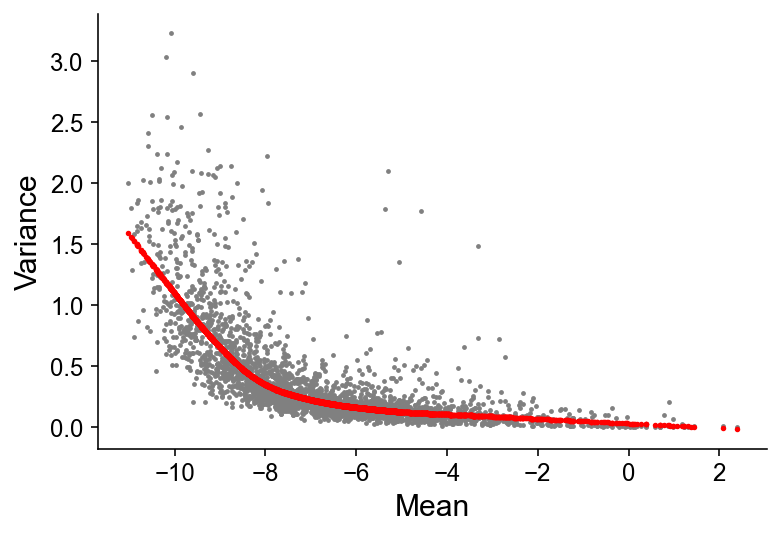

In [76]:
from scipy.interpolate import interp1d
import statsmodels.api as sm

lowess = sm.nonparametric.lowess(log_var, log_mean, frac=.3, return_sorted=False)

plt.scatter(log_mean, log_var, s=2.0, color='grey')
plt.scatter(log_mean, lowess, s=3.0, color='red')
plt.xlabel('Mean', fontsize=15)
plt.ylabel('Variance', fontsize=15)
plt.show()

Now calculate a ratio of observed log-variance compared to the LOWESS fit. We set a standard threshold of 1.3, with a log-mean threshold cutoff of -10.

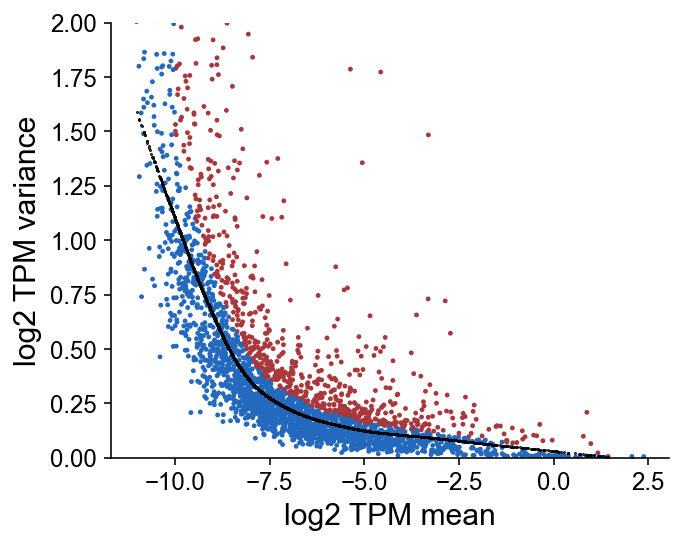

In [77]:
variance_ratio = log_var / lowess
var_thresh = 1.3
mean_thresh = -10
variable_genes = nonzero_genes[(variance_ratio > var_thresh) & (log_mean > mean_thresh)]
plt.figure(figsize=(5,4))
plt.scatter(log_mean, log_var, s=2.0, c=nonzero_genes.isin(variable_genes), cmap='vlag')
plt.scatter(log_mean, lowess, color='black', s=0.2)
plt.ylim(0, 2)
plt.xlabel('log2 TPM mean')
plt.ylabel('log2 TPM variance')
plt.show()

Calculate the fraction of genes classed as highly variable (here, 22%):

In [79]:
len(variable_genes) / angle_binned_expression.shape[1]

0.22084690553745928

Next, we calculate a deviance metric to distinguish divergent and non-divergent genes. This is simply the standard deviation of cell cycle expression after correcting for the replication effect:

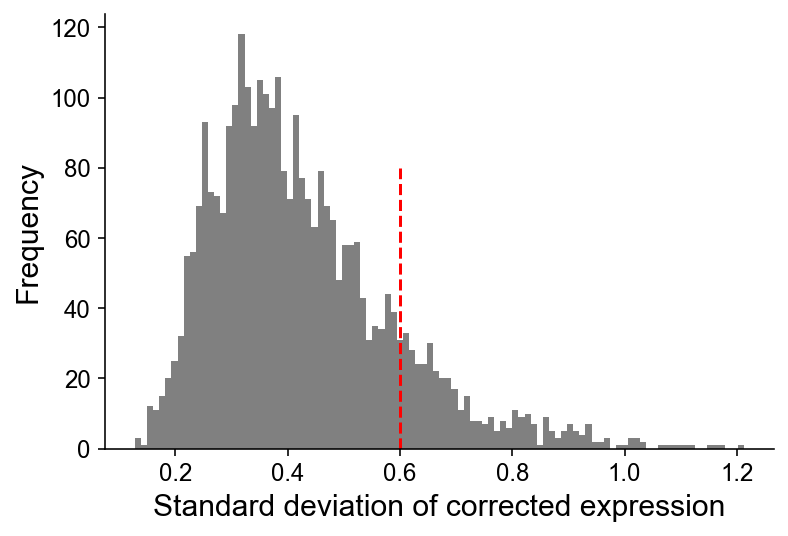

In [80]:
corrected_sd = corrected_expression.std()

plt.hist(corrected_sd, bins=100, color='grey')
plt.xlabel('Standard deviation of corrected expression')
plt.ylabel('Frequency')
plt.vlines(x=0.60, ymin=0, ymax=80, linestyles='dashed', color='red')
plt.show()

We class as divergent genes that are both highly variable *and* score above the threshold in the divergence score. In the paper we only include genes that meet the criteria for both replicates but here we can determine it for just one replicate:

In [83]:
len(corrected_sd[(corrected_sd > 0.6) & (corrected_sd.index.isin(variable_genes))]) / angle_binned_expression.shape[1]

0.045928338762214985

Here, 4.6% of genes fit these criteria. As we discover in the paper, many genes that are non-divergent fit a canonical gene dosage-dependent pattern of expression, whereas the divergent genes exhibit dynamics that arise due to other mechanisms. However, while useful for initial characterization, this divergence score likely under-estimates the number of genes that diverge from a gene-dosage pattern because it works with scaled data. Therefore, while it can account for divergences due to shape, delay etc., it does not account for amplitudes that are different from expectations.

### 5. Defining a zero angle to standardize cell cycle expression
We want to define a zero angle that allows us to compare across different replicates. While this standardization is the primary purpose, we want to give this some biological meaning. Therefore, we chose to take the predicted minimum expression of an imaginary gene at the origin of replication. This is because the minimum is likely to correspond approximately with the replication time (since dosage-dependent genes will increase in expression upon their replication).

First, predict cell cycle expression for a gene at the origin (the predicted minimum is taken from the Rstan analysis):

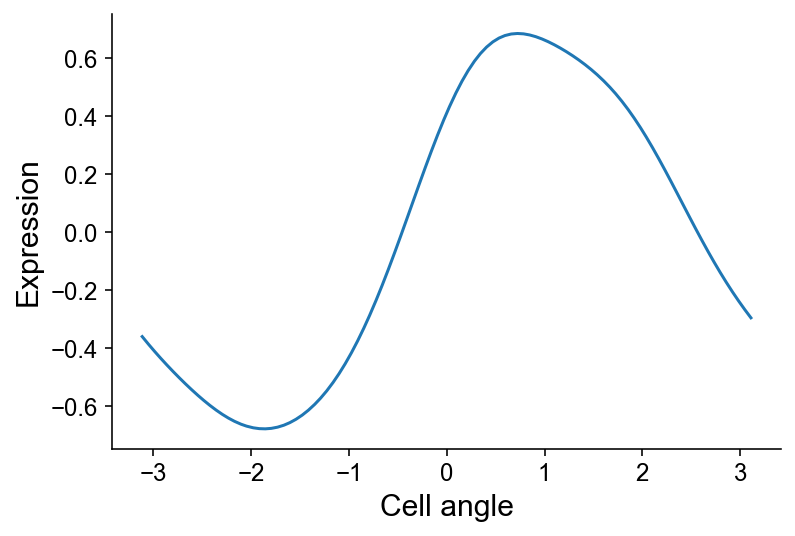

In [84]:
predicted_0_angle = -2.620387

X_0 = np.column_stack((cell_angle_means_radians,
                np.array([predicted_0_angle]*len(cell_angle_means_radians))))

X_0_full = make_interaction_matrix(X_0, interactions_only=False, degree=4)

y_0_pred = lm.predict(X_0_full)
plt.plot(X_0[:,0], y_0_pred)
plt.xlabel('Cell angle'); plt.ylabel('Expression')
plt.show()

Now determine the minimum cell angle bin:

In [85]:
cell_angle_means[np.where(y_0_pred == np.min(y_0_pred))][0]

73.79777526855469

The zero angle used in the paper is 62.9596°, reflecting the fact that the new angle estimates are slightly out of phase with the ones used in the paper.

We can save these data for downstream analysis, particularly the predicted and observed gene angles. The ones used in the paper itself are available at `samples/lb_gene_information.txt`.